# Graph Networts

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import tensorflow as tf

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import uproot3 as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mfong/git/LCStudies/'
plotpath = path_prefix + 'classifier/Plots/'
modelpath = path_prefix + 'classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/atlas_mpl_style/__init__.py:163: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  _warn.warn(


In [3]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
sys.path
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu

/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/atlas_mpl_style/__init__.py:163: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  _warn.warn(


In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=24220)]) #in MB

print("Num GPUs Available: ", len(gpus))
tf.config.list_physical_devices()


Num GPUs Available:  4


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:2', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:3', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [7]:
# import pi+- vs. pi0 images

inputpath = '/clusterfs/ml4hep/mfong/ML4Pions/v7/'    # ml4hep1 machine
# inputpath = "/data0/mfong/v7/"    # voltan machine
#path = '/eos/user/m/mswiatlo/images/'
branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'cluster_cellE_norm']
rootfiles = ["pi0", "piplus", "piminus"]
trees = {
    rfile : ur.open(inputpath+rfile+".root")['ClusterTree']
    for rfile in rootfiles
}
pdata = {
    ifile : itree.pandas.df(branches, flatten=False)
    for ifile, itree in trees.items()
}

np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [8]:
cell_shapes = {
    'EMB1': (128,4),
    'EMB2': (16,16),
    'EMB3': (8,16),
    'TileBar0': (4,4),
    'TileBar1': (4,4),
    'TileBar2': (2,4),
}

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer)
        for layer in layers
    }
    for ifile, itree in trees.items()
}

In [9]:
pdata["pi0"].columns

Index(['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi',
       'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt',
       'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE',
       'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T',
       'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY',
       'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT',
       'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min',
       'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max',
       'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max',
       'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi',
       'cluster_cell_centerCellLayer', 'cluster_cellE_norm'],
      dtype='object')

In [10]:
n_cells = 0
for key in pcells["pi0"]:
    print(pcells["pi0"][key].shape)
    n_cells += pcells["pi0"][key].shape[1]
print("Total number of cells: " + str(n_cells))

(263891, 512)
(263891, 256)
(263891, 128)
(263891, 16)
(263891, 16)
(263891, 8)
Total number of cells: 936


## Create DataFrame

In [11]:
# df for pi0 only
df_p0 = pd.DataFrame(np.concatenate([pcells["pi0"][key] for key in pcells["pi0"].keys()], axis = 1))

col_names = []
for key in pcells["pi0"].keys():
    col_names.extend([key + "_" + str(i) for i in range(len(pcells["pi0"][key][0]))])
df_p0.columns = col_names

df_p0["is_p0"] = 1


# print(df_p0.shape)
# df_p0.head()

In [12]:
# df for pipplus and piminus
df_pp = pd.DataFrame(np.concatenate([pcells["piplus"][key] for key in pcells["piplus"].keys()], axis = 1))
df_pp.columns = col_names
df_pp["is_p0"] = 0

df_pm = pd.DataFrame(np.concatenate([pcells["piminus"][key] for key in pcells["piminus"].keys()], axis = 1))
df_pm.columns = col_names
df_pm["is_p0"] = 0

# print(df_pp.shape)
# df_pp.head()

In [13]:
# create final df
df = df_p0.append(df_pp.append(df_pm))
df = df.sample(frac=1) # Shuffle the df so pi0 are not all first
df.reset_index(inplace = True, drop = True)
df.head()

,EMB1_0,EMB1_1,EMB1_2,EMB1_3,EMB1_4,EMB1_5,EMB1_6,EMB1_7,EMB1_8,EMB1_9,EMB1_10,EMB1_11,EMB1_12,EMB1_13,EMB1_14,EMB1_15,EMB1_16,EMB1_17,EMB1_18,EMB1_19,EMB1_20,EMB1_21,EMB1_22,EMB1_23,EMB1_24,EMB1_25,EMB1_26,EMB1_27,EMB1_28,EMB1_29,EMB1_30,EMB1_31,EMB1_32,EMB1_33,EMB1_34,EMB1_35,EMB1_36,EMB1_37,EMB1_38,EMB1_39,EMB1_40,EMB1_41,EMB1_42,EMB1_43,EMB1_44,EMB1_45,EMB1_46,EMB1_47,EMB1_48,EMB1_49,...,EMB3_119,EMB3_120,EMB3_121,EMB3_122,EMB3_123,EMB3_124,EMB3_125,EMB3_126,EMB3_127,TileBar0_0,TileBar0_1,TileBar0_2,TileBar0_3,TileBar0_4,TileBar0_5,TileBar0_6,TileBar0_7,TileBar0_8,TileBar0_9,TileBar0_10,TileBar0_11,TileBar0_12,TileBar0_13,TileBar0_14,TileBar0_15,TileBar1_0,TileBar1_1,TileBar1_2,TileBar1_3,TileBar1_4,TileBar1_5,TileBar1_6,TileBar1_7,TileBar1_8,TileBar1_9,TileBar1_10,TileBar1_11,TileBar1_12,TileBar1_13,TileBar1_14,TileBar1_15,TileBar2_0,TileBar2_1,TileBar2_2,TileBar2_3,TileBar2_4,TileBar2_5,TileBar2_6,TileBar2_7,is_p0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000009,0.000038,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.000224,0.000315,0.001344,0.000428,0.002322,0.012944,0.014262,0.002498,0.001551,0.070766,0.140632,0.001669,0.003287,0.004747,0.008165,0.000888,0.000054,0.000776,0.001186,0.000146,0.000375,0.006990,0.007225,0.003866,0.001419,0.035971,0.047344,0.003773,0.000361,0.006787,0.003358,0.002189,0.0,0.000625,0.000405,0.000031,0.000024,0.001023,0.001606,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.011872,0.005269,0.000000,0.000000,0.628931,0.088836,0.002091,0.000000,0.030488,0.019321,0.004342,0.000000,0.000000,0.000177,0.001947,0.000000,0.019718,0.003629,0.000000,0.000000,0.087662,0.022248,0.000901,0.000000,0.006445,0.000219,0.000237,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1


## Create Graphs

In [14]:
# permutations for doubly connected edges
from itertools import permutations
import functools
import networkx as nx
import sonnet as snt

from graph_nets import blocks

from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf

In [15]:
event0 = df.loc[0]
event0

EMB1_0        0.000000
EMB1_1        0.000000
EMB1_2        0.000000
EMB1_3        0.000000
EMB1_4        0.000000
                ...   
TileBar2_4    0.000024
TileBar2_5    0.001023
TileBar2_6    0.001606
TileBar2_7    0.000000
is_p0         0.000000
Name: 0, Length: 937, dtype: float64

In [92]:
def make_fully_connected_edges(nodes):
    """
    returns a list of tuples with (sender_node, reciever_node) for a fully connected graph
    ex: [(1,2), (2,1), (0,1)]
    """
    n_nodes = len(nodes)
    return list(permutations(range(n_nodes), 2))

In [93]:
def make_graph(event):
    
    n_nodes = 0
    nodes = []
    MIN_VALUE = 0.05
    solution = "is_p0"
    
    nodes = [[cell] for cell in event[col_names][event[col_names] > MIN_VALUE]]
    n_nodes = len(nodes)
    if n_nodes < 1:
        return (None, None)
    nodes = np.array(nodes, dtype=np.float32)
    
    edge_endpoints = make_fully_connected_edges(nodes)
    senders = np.array([x[0] for x in edge_endpoints])
    receivers = np.array([x[1] for x in edge_endpoints])
    n_edges = len(edge_endpoints)
    edges = np.expand_dims(np.array([0.0]*n_edges, dtype=np.float32), axis=1)

    
    input_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([n_nodes], dtype=np.float32)
    }
    target_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([event[solution]], dtype=np.float32)
    }
    input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])
    target_graph = utils_tf.data_dicts_to_graphs_tuple([target_datadict])
    
    return (input_graph, target_graph)

In [94]:
def print_graphs_tuple(g, data=True):
    for field_name in graphs.ALL_FIELDS:
        per_replica_sample = getattr(g, field_name)
        if per_replica_sample is None:
            print(field_name, "EMPTY")
        else:
            print(field_name, "has shape", per_replica_sample.shape)
            if data and  field_name != "edges":
                print(per_replica_sample)

In [95]:
graphs_tuple0_input, graphs_tuple0_target = make_graph(event0)

print_graphs_tuple(graphs_tuple0_input, data=False)

nodes has shape (4, 1)
edges has shape (12, 1)
receivers has shape (12,)
senders has shape (12,)
globals has shape (1, 1)
n_node has shape (1,)
n_edge has shape (1,)


In [115]:
graphs = []
for i in range(100):
    graphs.append(make_graph(df.loc[i]))

In [118]:
# [x[0] for x in graphs][0].n_node

for test_input, _ in graphs:
    if test_input is not None:
        print(test_input.n_edge)


tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([20], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([0], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([0], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([20], shape=(1,), dtype=int32)
tf.Tensor([0], shape=(1,), dtype=int32)
tf.Tensor([20], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([20], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), 

In [20]:
# plotting functions from example (broken)

# def plot_graph_networkx(graph, ax, pos=None):
#   node_labels = {node: "{:.3g}".format(data["features"][0])
#                  for node, data in graph.nodes(data=True)
#                  if data["features"] is not None}
#   edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
#                  for sender, receiver, data in graph.edges(data=True)
#                  if data["features"] is not None}
#   global_label = ("{:.3g}".format(graph.graph["features"][0])
#                   if graph.graph["features"] is not None else None)

#   if pos is None:
#     pos = nx.spring_layout(graph)
#   nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

#   if edge_labels:
#     nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

#   if global_label:
#     plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

#   ax.yaxis.set_visible(False)
#   ax.xaxis.set_visible(False)
#   return pos

# def plot_graphs_tuple(graphs_tuple):
#   networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
#   num_graphs = len(networkx_graphs)
#   _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
#   if num_graphs == 1:
#     axes = axes,
#   for graph, ax in zip(networkx_graphs, axes):
#     plot_graph_networkx(graph, ax)

# plot_graphs_tuple(graphs_tuple0_input)

## Graph net

In [21]:
# Need the newest dev version of graph_nets (see https://github.com/deepmind/graph_nets/issues/139)
# as of 3/25/2021


# !pip install git+git://github.com/deepmind/graph_nets.git

In [22]:
NUM_LAYERS = 2
def make_mlp_model():
  """Instantiates a new MLP, followed by LayerNorm.

  The parameters of each new MLP are not shared with others generated by
  this function.

  Returns:
    A Sonnet module which contains the MLP and LayerNorm.
  """
  # the activation function choices:
  # swish, relu, relu6, leaky_relu
  return snt.Sequential([
      snt.nets.MLP([128, 64]*NUM_LAYERS,
                    activation=tf.nn.relu,
                    activate_final=True, 
                  #  dropout_rate=DROPOUT_RATE
        ),
      snt.LayerNorm(axis=-1, create_scale=True, create_offset=False)
  ])

In [262]:
class MLPGraphNetwork(snt.Module):
    """GraphIndependent with MLP edge, node, and global models."""
    def __init__(self, name="MLPGraphNetwork"):
        super(MLPGraphNetwork, self).__init__(name=name)
        self._network = modules.GraphNetwork(
            edge_model_fn=make_mlp_model,
            node_model_fn=make_mlp_model,
            global_model_fn=make_mlp_model
            )

    def __call__(self, inputs,
            edge_model_kwargs=None,
            node_model_kwargs=None,
            global_model_kwargs=None):
        return self._network(inputs,
                      edge_model_kwargs=edge_model_kwargs,
                      node_model_kwargs=node_model_kwargs,
                      global_model_kwargs=global_model_kwargs)

In [263]:
LATENT_SIZE = 128
NUM_LAYERS = 3

class GlobalClassifierNoEdgeInfo(snt.Module):

    def __init__(self, name="GlobalClassifierNoEdgeInfo"):
        super(GlobalClassifierNoEdgeInfo, self).__init__(name=name)

        self._edge_block = blocks.EdgeBlock(
            edge_model_fn=make_mlp_model,
            use_edges=False,              # all edge features are 0.0 right now, use false for now
            use_receiver_nodes=True,
            use_sender_nodes=True,
            use_globals=False,            # can try true later
            name='edge_encoder_block')

        self._node_encoder_block = blocks.NodeBlock(
            node_model_fn=make_mlp_model,
            use_received_edges=False,      # if assigning edge features set to true
            use_sent_edges=False,          # if assigning edge features set to true
            use_nodes=True,
            use_globals=False,             # can try true later to see if any effect
            name='node_encoder_block'
        )

        self._global_block = blocks.GlobalBlock(
            global_model_fn=make_mlp_model,
            use_edges=True,
            use_nodes=True,
            use_globals=True,
        )

        self._core = MLPGraphNetwork()
        # Transforms the outputs into appropriate shapes.
        global_output_size = 1
        global_fn = lambda: snt.Sequential([
            snt.nets.MLP([LATENT_SIZE, global_output_size], name='global_output'),       # TODO add more layers, end with size 1
            tf.sigmoid
        ])

        self._output_transform = modules.GraphIndependent(None, None, global_fn)

    def __call__(self, input_op, num_processing_steps):
        latent = self._global_block(self._edge_block(self._node_encoder_block(input_op)))
        latent0 = latent

        output_ops = []
        for _ in range(num_processing_steps):
            core_input = utils_tf.concat([latent0, latent], axis=1)
            latent = self._core(core_input)
            output_ops.append(self._output_transform(latent))

        return output_ops

In [264]:
model = GlobalClassifierNoEdgeInfo()

In [265]:
output_graphs = model(graphs_tuple0_input, 1)

In [266]:
[x.globals for x in output_graphs]

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5559923]], dtype=float32)>]

In [267]:
# Loss function:

class GlobalLoss:
    def __init__(self, real_global_weight, fake_global_weight):
        self.w_global_real = real_global_weight
        self.w_global_fake = fake_global_weight

    def __call__(self, target_op, output_ops):
        global_weights = target_op.globals * self.w_global_real \
            + (1 - target_op.globals) * self.w_global_fake
        
        print(global_weights)
        
        loss_ops = [
            tf.compat.v1.losses.log_loss(target_op.globals, output_op.globals, weights=global_weights)
            for output_op in output_ops
        ]
        return tf.stack(loss_ops)

In [268]:
loss_function_global = GlobalLoss(real_global_weight = 1.0, fake_global_weight = 1.0)

In [269]:
loss_function_global(graphs_tuple0_target, output_graphs)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8119132], dtype=float32)>

In [201]:
input_list = []
target_list = []
counter = 0
index = 0
# while counter < 100:
#     input_graph, target_graph = train_graphs[index]
#     if input_graph is None:
#         index += 1
#         continue
#     target_list.append(target_graph)
#     input_list.append(input_graph)
#     counter += 1

# concated_inputs = utils_tf.concat(input_list, axis=0)
# concated_targets = utils_tf.concat(target_graph, axis=0)


for data in train_graphs[:1000]:
    input_tr, target_tr = data
    if input_tr is None:
            continue
    input_list.append(input_tr)
    target_list.append(target_tr)
    if len(input_list) >= batch_size:
        input_tr = utils_tf.concat(input_list, axis=0)
        target_tr = utils_tf.concat(target_list, axis=0)
        x = model(input_tr, 1)
        break


In [164]:
utils_tf.concat(target_list, axis=0).globals

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.]], dtype=float32)>

In [199]:
loss_function_global(model(input_tr, 1)[-1], utils_tf.concat(target_list, axis=0))

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'globals'

In [211]:
utils_tf.get_graph(input_tr, index = 0).nodes

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.48329577],
       [3.3163548 ],
       [0.751511  ],
       [4.6038504 ]], dtype=float32)>

In [212]:
utils_tf.get_graph(input_tr, index = 1).nodes

<tf.Tensor: shape=(6, 1), dtype=float32, numpy=
array([[0.39807805],
       [0.81405723],
       [1.6258401 ],
       [4.9596205 ],
       [1.8701465 ],
       [0.7057205 ]], dtype=float32)>

In [221]:
model(utils_tf.get_graph(input_tr, index = 0), 4)[-1].globals

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.33847168]], dtype=float32)>

In [200]:
tf.compat.v1.losses.log_loss(utils_tf.concat(target_list, axis=0).globals, model(input_tr, 1)[-1].globals)

ValueError: Shapes (1, 1) and (2, 1) are incompatible

In [256]:
model(input_tr, 1)[-1].globals

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.26044545],
       [0.24761927]], dtype=float32)>

In [260]:
model(input_tr, 2)[-1].globals

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.26017097],
       [0.2465775 ]], dtype=float32)>

In [258]:
model(input_tr, 4)[0].globals

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.26044542],
       [0.24761927]], dtype=float32)>

## Model Training

In [34]:
# TODO modify acc function

# def compute_accuracy(target, output):
#     """Calculate model accuracy.

#     Returns the number of correctly predicted links and the number
#     of completely solved list sorts (100% correct predictions).

#     Args:
#     target: A `graphs.GraphsTuple` that contains the target graph.
#     output: A `graphs.GraphsTuple` that contains the output graph.

#     Returns:
#     correct: A `float` fraction of correctly labeled nodes/edges.
#     solved: A `float` fraction of graphs that are completely correctly labeled.
#     """
#     tdds = utils_np.graphs_tuple_to_data_dicts(target)
#     odds = utils_np.graphs_tuple_to_data_dicts(output)
#     cs = []
#     ss = []
#     for td, od in zip(tdds, odds):
#         num_elements = td["nodes"].shape[0]
#         xn = np.argmax(td["nodes"], axis=-1)
#         yn = np.argmax(od["nodes"], axis=-1)

#         xe = np.reshape(
#             np.argmax(
#                 np.reshape(td["edges"], (num_elements, num_elements, 2)), axis=-1),
#             (-1,))
#         ye = np.reshape(
#             np.argmax(
#                 np.reshape(od["edges"], (num_elements, num_elements, 2)), axis=-1),
#             (-1,))
#         c = np.concatenate((xn == yn, xe == ye), axis=0)
#         s = np.all(c)
#         cs.append(c)
#         ss.append(s)
#     correct = np.mean(np.concatenate(cs, axis=0))
#     solved = np.mean(np.stack(ss))
#     return correct, solved

In [63]:
def get_signature(dataset, batch_size):
    """
    Get signature of inputs for the training loop.
    The signature is used by the tf.function
    """

    input_list = []
    target_list = []
    for _, data in dataset.iterrows():
        dd = make_graph(data)
        if dd[0] is not None:
            input_list.append(dd[0])
            target_list.append(dd[1])
            
        if len(input_list) == batch_size:
            break

    inputs = utils_tf.concat(input_list, axis=0)
    targets = utils_tf.concat(target_list, axis=0)
    input_signature = (
      utils_tf.specs_from_graphs_tuple(inputs),
      utils_tf.specs_from_graphs_tuple(targets)
    )
    
    return input_signature

In [270]:
batch_size = 50
input_signature = get_signature(df, batch_size)


# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 2
num_processing_steps_ge = 2


learning_rate = 5e-4
optimizer = snt.optimizers.Adam(learning_rate)


# model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
last_iteration = 0
generalization_iteration = 0

logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []


@functools.partial(tf.function, input_signature=input_signature)
def update_step(inputs_tr, targets_tr):
    print("Tracing update_step")
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, num_processing_steps_tr)
        loss_ops_tr = loss_function_global(targets_tr, outputs_tr)
        loss_op_tr = tf.math.reduce_sum(loss_ops_tr) / tf.constant(num_processing_steps_tr, dtype=tf.float32)

    gradients = tape.gradient(loss_op_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_op_tr

In [52]:
from sklearn.model_selection import train_test_split

# train and generalization df
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

In [47]:
# normalize values to gaussian
from sklearn.preprocessing import StandardScaler

# fit scaler to train set
scaler = StandardScaler()
scaler.fit(df_train.drop("is_p0", axis=1))

# scale the train set
df_train_scaled = pd.DataFrame(scaler.transform(df_train.drop("is_p0", axis=1)))
df_train_scaled["is_p0"] = df_train["is_p0"].values
df_train_scaled.columns = df_train.columns

# scale the test set
df_test_scaled = pd.DataFrame(scaler.transform(df_test.drop("is_p0", axis=1)))
df_test_scaled["is_p0"] = df_test["is_p0"].values
df_test_scaled.columns = df_test.columns

In [48]:
%%time
# TODO this is very slow (1.5 hours for full 1100000 row dataset)
# 5 min for 50000 rows
# make graphs for each event
train_graphs = [make_graph(event) for _, event in df_train_scaled[:50000].iterrows()]
test_graphs = [make_graph(event) for _, event in df_test_scaled[:5000].iterrows()]

CPU times: user 5min 40s, sys: 14.6 s, total: 5min 55s
Wall time: 4min 51s


In [ ]:
"""
save train_graphs and test_graphs objects to file, it takes too long to make
"""
import pickle

def save_object(obj, filename):
    with open(filename, "wb") as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

save_object(train_graphs, "Temp/train_graphs_scaled.pkl")
save_object(train_graphs, "Temp/test_graphs_scaled.pkl")

"""
Load the graph dataset from pickle object files
"""
# file = open("Temp/train_graphs.pkl",'rb')
# train_graphs = pickle.load(file)
# file.close()

# file = open("Temp/test_graphs.pkl",'rb')
# test_graphs = pickle.load(file)
# file.close()


In [122]:
def loop_dataset(datasets, batch_size):
    if batch_size > 0:
        in_list = []
        target_list = []
        for dataset in datasets:
            inputs_tr, targets_tr = dataset
            if inputs_tr is None:
                continue
            in_list.append(inputs_tr)
            target_list.append(targets_tr)
            if len(in_list) == batch_size:
                inputs_tr = utils_tf.concat(in_list, axis=0)
                targets_tr = utils_tf.concat(target_list, axis=0)
                yield (inputs_tr, targets_tr)
                in_list = []
                target_list = []
    else:
        for dataset in datasets:
            if dataset is None:
                continue
            yield dataset

In [123]:
# create generator that yields a graph of the batch_size concatenated graphs
training_data = loop_dataset(train_graphs, batch_size)

In [124]:
input_tr, target_tr = next(training_data)

In [125]:
len(train_graphs)

907588

Loss: 0.4610453248023987
Loss: 0.46114158630371094
Loss: 0.4609955847263336
Loss: 0.46059614419937134
Loss: 0.4599519670009613
Loss: 0.45918089151382446
Loss: 0.4583708941936493
Loss: 0.4576148986816406
Loss: 0.45698490738868713
Loss: 0.45671215653419495
Loss: 0.4567072093486786
Loss: 0.45671185851097107
Loss: 0.4566919505596161
Loss: 0.4566284120082855
Loss: 0.45650988817214966
Loss: 0.45633697509765625
Loss: 0.4561152458190918
Loss: 0.4558555781841278
Loss: 0.455574095249176
Loss: 0.4552818238735199
Loss: 0.45498958230018616
Loss: 0.45475897192955017
Loss: 0.45455238223075867
Loss: 0.45436397194862366
Loss: 0.45421481132507324
Loss: 0.45408591628074646
Loss: 0.45397621393203735
Loss: 0.45388126373291016
Loss: 0.45382919907569885
Loss: 0.4537911117076874
Loss: 0.4537179172039032
Loss: 0.45358729362487793
Loss: 0.45342347025871277
Loss: 0.4533112049102783
Loss: 0.4532068371772766
Loss: 0.4531041085720062
Loss: 0.45301198959350586
Loss: 0.45291003584861755
Loss: 0.4528124928474426
Loss:

Loss: 0.44544848799705505
Loss: 0.44403859972953796
Loss: 0.44055911898612976
Loss: 0.43759337067604065
Loss: 0.43737897276878357
Loss: 0.4388492703437805
Loss: 0.43996405601501465
Loss: 0.439524382352829
Loss: 0.4380801320075989
Loss: 0.4365186393260956
Loss: 0.4357764720916748
Loss: 0.4368588626384735
Loss: 0.43747687339782715
Loss: 0.4372813403606415
Loss: 0.43568140268325806
Loss: 0.4355982840061188
Loss: 0.4357256591320038
Loss: 0.4361606538295746
Loss: 0.43610525131225586
Loss: 0.43529319763183594
Loss: 0.43468141555786133
Loss: 0.4342148005962372
Loss: 0.43448305130004883
Loss: 0.43468475341796875
Loss: 0.4344322681427002
Loss: 0.43388763070106506
Loss: 0.433403879404068
Loss: 0.43238577246665955
Loss: 0.4315546154975891
Loss: 0.4293740391731262
Loss: 0.43262630701065063
Loss: 0.4293522834777832
Loss: 0.42892083525657654
Loss: 0.42872077226638794
Loss: 0.4277072548866272
Loss: 0.42766162753105164
Loss: 0.4314729869365692
Loss: 0.42631635069847107
Loss: 0.42728081345558167
Loss: 

Loss: 0.4308857023715973
Loss: 0.43087682127952576
Loss: 0.43086716532707214
Loss: 0.4308602511882782
Loss: 0.4308500289916992
Loss: 0.4308426082134247
Loss: 0.43083611130714417
Loss: 0.43082910776138306
Loss: 0.43082156777381897
Loss: 0.43081504106521606
Loss: 0.4308067858219147
Loss: 0.4307992160320282
Loss: 0.4307912290096283
Loss: 0.4307463765144348
Loss: 0.43044567108154297
Loss: 0.4302522838115692
Loss: 0.4302145540714264
Loss: 0.43021222949028015
Loss: 0.4301634728908539
Loss: 0.4300857484340668
Loss: 0.4299876391887665
Loss: 0.42953696846961975
Loss: 0.4292953908443451
Loss: 0.4292401373386383
Loss: 0.4292328357696533
Loss: 0.4291853606700897
Loss: 0.42911654710769653
Loss: 0.4288499057292938
Loss: 0.4262668788433075
Loss: 0.43281012773513794
Loss: 0.43223172426223755
Loss: 0.435034841299057
Loss: 0.4402187764644623
Loss: 0.44090184569358826
Loss: 0.43937644362449646
Loss: 0.4348908066749573
Loss: 0.43414339423179626
Loss: 0.43311840295791626
Loss: 0.43350887298583984
Loss: 0.4

Loss: 0.4279020428657532
Loss: 0.4272925555706024
Loss: 0.42729830741882324
Loss: 0.4272356927394867
Loss: 0.42707759141921997
Loss: 0.42702850699424744
Loss: 0.42700520157814026
Loss: 0.4270939528942108
Loss: 0.42723575234413147
Loss: 0.4271114766597748
Loss: 0.427308052778244
Loss: 0.42694613337516785
Loss: 0.42721039056777954
Loss: 0.4271722435951233
Loss: 0.4271012842655182
Loss: 0.42742329835891724
Loss: 0.4273340702056885
Loss: 0.42786332964897156
Loss: 0.42699310183525085
Loss: 0.4273781478404999
Loss: 0.4274516999721527
Loss: 0.42731761932373047
Loss: 0.42686089873313904
Loss: 0.4427924156188965
Loss: 0.4347112774848938
Loss: 0.4398256838321686
Loss: 0.44024354219436646
Loss: 0.4473641812801361
Loss: 0.4431036114692688
Loss: 0.43939897418022156


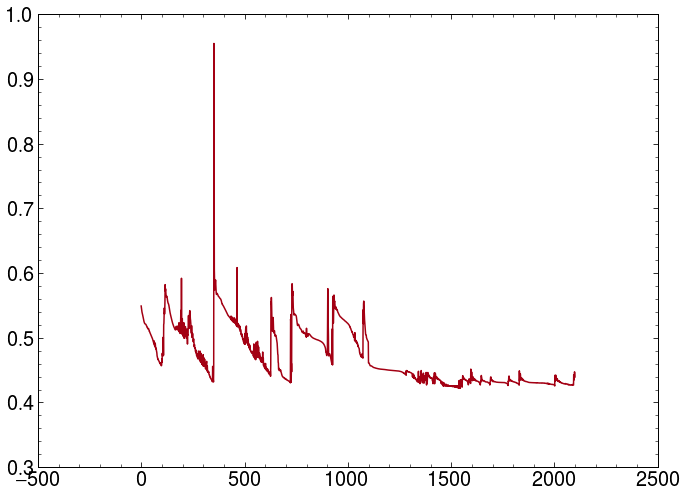

In [233]:
# repeatedly learning on same set of training data to make sure loss goes down
# temp_loss = []

for x in range(1000):
    temp_curr_loss = update_step(input_tr, target_tr)[1].numpy()
    print(f"Loss: {temp_curr_loss}")
    temp_loss.append(temp_curr_loss)
plt.plot(temp_loss)

In [252]:
# Data / training parameters.
num_training_iterations = 20


# for epoch in range(1000):
#     total_loss = 0.
#     num_batches = 0
    
#     for _ in range(num_training_iterations):
#         input_tr, target_tr = next(training_data)
#         total_loss += update_step(input_tr, target_tr)[1].numpy()
#         num_batches += 1
        
#     loss_tr = total_loss / num_batches
#     losses_tr.append(loss_tr)
#     print(f"Epoch: {epoch}\tLoss value: {loss_tr}")

current_loss_list = []
for epoch in range(2):
    total_loss = 0.
    num_batches = 0
    
    input_list = []
    target_list = []
    
    
    
    for data in train_graphs[:10000]:
        input_tr, target_tr = data
        if input_tr is None:
                continue
        input_list.append(input_tr)
        target_list.append(target_tr)
        if len(input_list) >= batch_size:
            input_tr = utils_tf.concat(input_list, axis=0)
            target_tr = utils_tf.concat(target_list, axis=0)
            
            current_loss = update_step(input_tr, target_tr)[1].numpy()
            total_loss += current_loss
            
            if num_batches % 10 == 0:
                current_loss_list.append(current_loss)
            
            num_batches += 1
            input_list = []
            target_list = []
            
            # TODO add a checkpoint > save to disk
    
    loss_tr = total_loss / num_batches
    losses_tr.append(loss_tr)
    print(f"Epoch: {epoch}\tLoss value: {loss_tr}")

Tracing update_step
Tensor("add:0", shape=(2, 1), dtype=float32)


/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Tracing update_step
Tensor("add:0", shape=(2, 1), dtype=float32)
Epoch: 0	Loss value: 0.49605690229602617
Epoch: 1	Loss value: 0.469543155003777


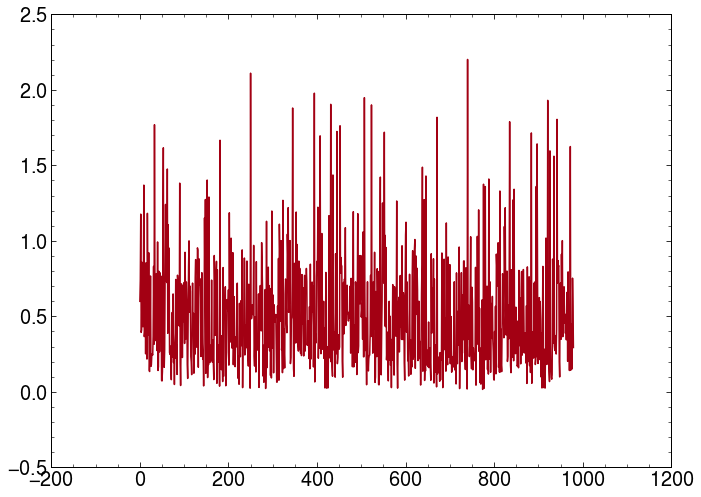

In [253]:
plt.plot(current_loss_list)

In [196]:
current_loss_list

[0.6730337,
 0.7149936,
 0.5890162,
 0.54679006,
 0.58873975,
 0.5885728,
 0.5884215,
 0.67305243,
 0.63059044,
 0.6305102,
 0.5451983,
 0.5449486,
 0.5447013,
 0.5444737,
 0.5442756,
 0.6730839,
 0.5869217,
 0.6299274,
 0.67309844,
 0.673104,
 0.58632314,
 0.67311335,
 0.62958753,
 0.67312133,
 0.6294978,
 0.5857421,
 0.54178,
 0.67314464,
 0.6292023,
 0.541086,
 0.5408517,
 0.54058236,
 0.5846182,
 0.62881887,
 0.53988093,
 0.6286879,
 0.5394466,
 0.49453974,
 0.58367634,
 0.58350027,
 0.53846425,
 0.6282753,
 0.62824035,
 0.53804016,
 0.62812287,
 0.6280557,
 0.5374398,
 0.5372395,
 0.5370267,
 0.5822889,
 0.5821369,
 0.5820322,
 0.6276287,
 0.62756103,
 0.7191961,
 0.67335516,
 0.5355054,
 0.5813291,
 0.71946126,
 0.48882872,
 0.62718385,
 0.5808379,
 0.58070517,
 0.5805603,
 0.6269304,
 0.62687194,
 0.58020365,
 0.72013485,
 0.58002704,
 0.67347527,
 0.6266401,
 0.57965595,
 0.5794926,
 0.5793506,
 0.53208977,
 0.67354333,
 0.48442024,
 0.53149307,
 0.673577,
 0.5311543,
 0.578510